# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 20 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 20, 20)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(1000, 2, 20, 20)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(2000, 2, 20, 20)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 20, 20), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creamos función de costo

In [20]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 20,20))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 20,20))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 20)
    y2 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 20,20))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 20,20))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 20)
    y22 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:
model = Sequential()
model.add(Flatten(input_shape=(2, 20, 20)))
model.add(BatchNormalization())
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(7))

In [23]:

model.add(Flatten(input_shape=(2,20,20)))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(128,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))

model.add(Dense(7, activation= custom_activation))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 800)               0         
                                                                 
 batch_normalization (BatchN  (None, 800)              3200      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               80100     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                        

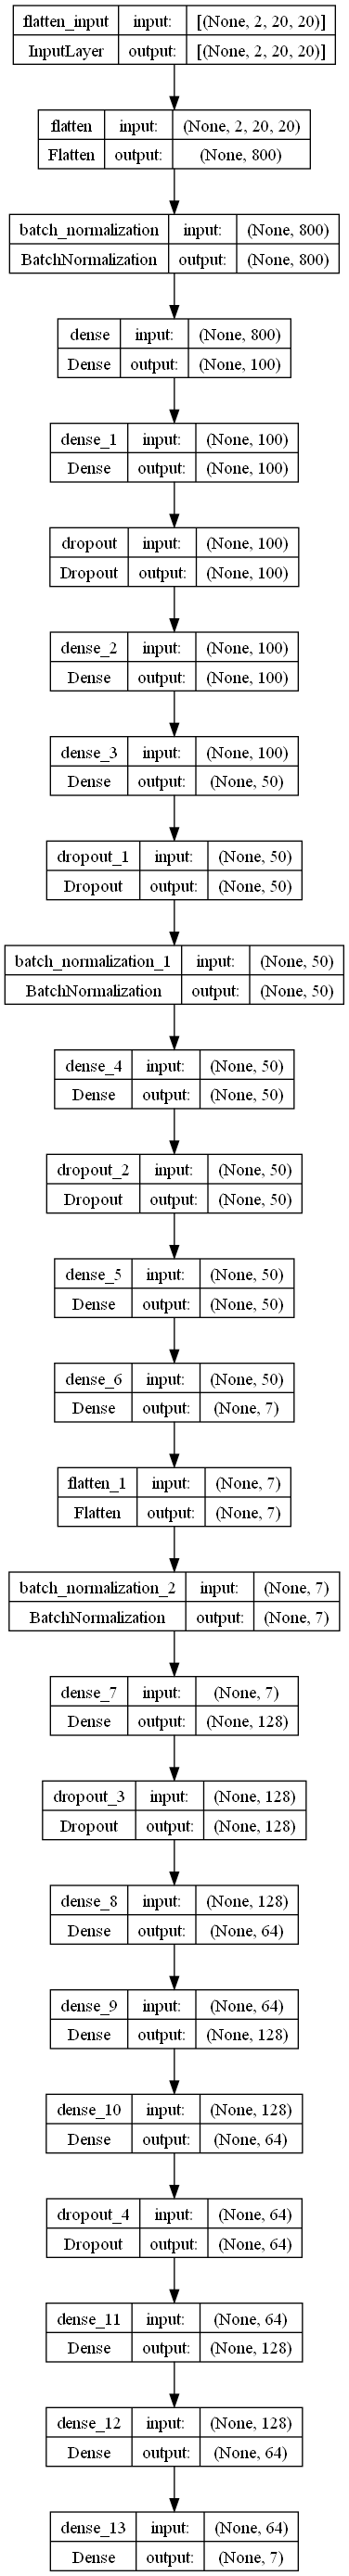

In [25]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [26]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [27]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [28]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [29]:
model.compile(optimizer=optimizer,
              loss= custom_loss,
              metrics=metrics)

In [30]:
def scheduler(epoch, lr):
  if epoch < 500:
    return lr
  else:
    return 1e-3 * 0.99 ** epoch

In [31]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 4s 3ms/step - loss: 44.3565 - a_1: 2.9710 - a_2: 3.2032 - b_1: 3.3656 - b_2: 3.1221 - d_1: 1.6136 - d_2: 1.6890 - n: 3.1677 - mean_metric: 0.6326 - val_loss: 33.5170 - val_a_1: 3.0157 - val_a_2: 3.0237 - val_b_1: 3.3622 - val_b_2: 3.1237 - val_d_1: 1.1590 - val_d_2: 1.0927 - val_n: 3.6583 - val_mean_metric: 0.6041 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 1s 2ms/step - loss: 40.6527 - a_1: 2.9702 - a_2: 3.0088 - b_1: 3.0808 - b_2: 3.0854 - d_1: 1.4731 - d_2: 1.4968 - n: 3.7599 - mean_metric: 0.6238 - val_loss: 33.5829 - val_a_1: 2.9991 - val_a_2: 2.9194 - val_b_1: 2.9386 - val_b_2: 2.9201 - val_d_1: 1.1150 - val_d_2: 1.1388 - val_n: 3.8518 - val_mean_metric: 0.5862 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 1s 2ms/step - loss: 38.8157 - a_1: 2.9192 - a_2: 2.9093 - b_1: 2.9517 - b_2: 2.9821 - d_1: 1.3867 - d_2: 1.4264 - n: 3.9902 - mean_metric: 0.6139 - val_loss: 31.8610 - val_a_

700/700 [==============================] - 1s 2ms/step - loss: 32.5436 - a_1: 2.8281 - a_2: 2.8881 - b_1: 2.8133 - b_2: 2.8363 - d_1: 1.2877 - d_2: 1.3048 - n: 4.5623 - mean_metric: 0.6126 - val_loss: 26.3324 - val_a_1: 2.9214 - val_a_2: 2.9005 - val_b_1: 2.8203 - val_b_2: 2.7986 - val_d_1: 0.9808 - val_d_2: 0.9789 - val_n: 4.5414 - val_mean_metric: 0.5885 - lr: 0.0010
Epoch 23/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.3096 - a_1: 2.8253 - a_2: 2.8932 - b_1: 2.8196 - b_2: 2.8534 - d_1: 1.3056 - d_2: 1.2957 - n: 4.5469 - mean_metric: 0.6134 - val_loss: 27.5327 - val_a_1: 2.8465 - val_a_2: 2.8839 - val_b_1: 2.7739 - val_b_2: 2.8157 - val_d_1: 1.1226 - val_d_2: 1.0102 - val_n: 4.8207 - val_mean_metric: 0.5989 - lr: 0.0010
Epoch 24/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.4624 - a_1: 2.8374 - a_2: 2.8880 - b_1: 2.7904 - b_2: 2.8554 - d_1: 1.3154 - d_2: 1.3200 - n: 4.5029 - mean_metric: 0.6124 - val_loss: 27.4042 - val_a_1: 2.8943 -

700/700 [==============================] - 1s 2ms/step - loss: 31.1374 - a_1: 2.8215 - a_2: 2.8909 - b_1: 2.7922 - b_2: 2.8317 - d_1: 1.2747 - d_2: 1.2970 - n: 2.8441 - mean_metric: 0.5544 - val_loss: 26.1409 - val_a_1: 2.9383 - val_a_2: 2.8965 - val_b_1: 2.7417 - val_b_2: 2.6971 - val_d_1: 1.0441 - val_d_2: 1.0193 - val_n: 2.9878 - val_mean_metric: 0.5347 - lr: 0.0010
Epoch 44/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.0414 - a_1: 2.8300 - a_2: 2.8608 - b_1: 2.7864 - b_2: 2.8385 - d_1: 1.2835 - d_2: 1.2838 - n: 2.7555 - mean_metric: 0.5504 - val_loss: 26.5528 - val_a_1: 2.9274 - val_a_2: 2.9023 - val_b_1: 2.7755 - val_b_2: 2.7833 - val_d_1: 1.0851 - val_d_2: 1.0270 - val_n: 2.8452 - val_mean_metric: 0.5356 - lr: 0.0010
Epoch 45/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.9378 - a_1: 2.8227 - a_2: 2.8772 - b_1: 2.7750 - b_2: 2.8598 - d_1: 1.2639 - d_2: 1.3075 - n: 2.6720 - mean_metric: 0.5487 - val_loss: 26.5806 - val_a_1: 2.8631 -

700/700 [==============================] - 1s 2ms/step - loss: 31.1151 - a_1: 2.8246 - a_2: 2.8792 - b_1: 2.7624 - b_2: 2.8185 - d_1: 1.2649 - d_2: 1.3011 - n: 1.9668 - mean_metric: 0.5231 - val_loss: 27.1512 - val_a_1: 2.8987 - val_a_2: 2.8907 - val_b_1: 2.7358 - val_b_2: 2.7067 - val_d_1: 1.0306 - val_d_2: 1.1385 - val_n: 2.0267 - val_mean_metric: 0.5053 - lr: 0.0010
Epoch 65/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.9364 - a_1: 2.8348 - a_2: 2.8695 - b_1: 2.7888 - b_2: 2.8068 - d_1: 1.3266 - d_2: 1.3410 - n: 2.0632 - mean_metric: 0.5302 - val_loss: 26.8610 - val_a_1: 2.8928 - val_a_2: 2.8366 - val_b_1: 2.8073 - val_b_2: 2.7323 - val_d_1: 1.0424 - val_d_2: 1.0852 - val_n: 2.2894 - val_mean_metric: 0.5139 - lr: 0.0010
Epoch 66/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.2125 - a_1: 2.8144 - a_2: 2.8754 - b_1: 2.7740 - b_2: 2.8276 - d_1: 1.2823 - d_2: 1.3080 - n: 2.1877 - mean_metric: 0.5315 - val_loss: 26.6859 - val_a_1: 2.9380 -

700/700 [==============================] - 1s 2ms/step - loss: 31.4600 - a_1: 2.8104 - a_2: 2.8748 - b_1: 2.7654 - b_2: 2.8066 - d_1: 1.3246 - d_2: 1.2626 - n: 1.8157 - mean_metric: 0.5178 - val_loss: 27.7146 - val_a_1: 2.8465 - val_a_2: 2.9088 - val_b_1: 2.7528 - val_b_2: 2.7207 - val_d_1: 1.1943 - val_d_2: 1.0053 - val_n: 1.9237 - val_mean_metric: 0.5029 - lr: 0.0010
Epoch 86/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.4940 - a_1: 2.8173 - a_2: 2.8455 - b_1: 2.7712 - b_2: 2.8018 - d_1: 1.4237 - d_2: 1.2751 - n: 1.8375 - mean_metric: 0.5215 - val_loss: 28.8534 - val_a_1: 2.9176 - val_a_2: 2.9138 - val_b_1: 2.8508 - val_b_2: 2.6949 - val_d_1: 1.2792 - val_d_2: 1.0120 - val_n: 1.8510 - val_mean_metric: 0.5082 - lr: 0.0010
Epoch 87/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.8767 - a_1: 2.8597 - a_2: 2.8851 - b_1: 2.8054 - b_2: 2.7773 - d_1: 1.3125 - d_2: 1.3197 - n: 1.9436 - mean_metric: 0.5257 - val_loss: 27.0918 - val_a_1: 2.9283 -

700/700 [==============================] - 1s 2ms/step - loss: 32.9816 - a_1: 2.8274 - a_2: 2.8524 - b_1: 2.7611 - b_2: 2.8428 - d_1: 1.3550 - d_2: 1.3515 - n: 1.7721 - mean_metric: 0.5213 - val_loss: 28.6594 - val_a_1: 2.8885 - val_a_2: 2.8538 - val_b_1: 2.7797 - val_b_2: 2.7284 - val_d_1: 1.2029 - val_d_2: 1.0577 - val_n: 1.7019 - val_mean_metric: 0.4983 - lr: 0.0010
Epoch 107/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.2194 - a_1: 2.8445 - a_2: 2.8630 - b_1: 2.7821 - b_2: 2.8016 - d_1: 1.3462 - d_2: 1.2937 - n: 1.7456 - mean_metric: 0.5183 - val_loss: 27.7612 - val_a_1: 2.8509 - val_a_2: 2.8800 - val_b_1: 2.8189 - val_b_2: 2.7610 - val_d_1: 1.0663 - val_d_2: 1.0930 - val_n: 1.7564 - val_mean_metric: 0.4990 - lr: 0.0010
Epoch 108/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.0847 - a_1: 2.8258 - a_2: 2.8876 - b_1: 2.7794 - b_2: 2.8148 - d_1: 1.2921 - d_2: 1.3122 - n: 1.7680 - mean_metric: 0.5185 - val_loss: 27.6529 - val_a_1: 2.8580

700/700 [==============================] - 1s 2ms/step - loss: 32.5403 - a_1: 2.8200 - a_2: 2.8453 - b_1: 2.7691 - b_2: 2.8160 - d_1: 1.3902 - d_2: 1.2625 - n: 1.7064 - mean_metric: 0.5158 - val_loss: 28.6958 - val_a_1: 2.8498 - val_a_2: 2.8446 - val_b_1: 2.7812 - val_b_2: 2.7944 - val_d_1: 1.2632 - val_d_2: 1.0323 - val_n: 1.6087 - val_mean_metric: 0.4971 - lr: 0.0010
Epoch 128/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.3600 - a_1: 2.8289 - a_2: 2.8726 - b_1: 2.8103 - b_2: 2.8015 - d_1: 1.3509 - d_2: 1.3002 - n: 1.6529 - mean_metric: 0.5163 - val_loss: 26.8242 - val_a_1: 2.8500 - val_a_2: 2.9031 - val_b_1: 2.8048 - val_b_2: 2.8003 - val_d_1: 1.0617 - val_d_2: 1.0425 - val_n: 1.6481 - val_mean_metric: 0.4949 - lr: 0.0010
Epoch 129/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.9678 - a_1: 2.8131 - a_2: 2.8744 - b_1: 2.7643 - b_2: 2.8427 - d_1: 1.3208 - d_2: 1.3025 - n: 1.8140 - mean_metric: 0.5205 - val_loss: 28.7449 - val_a_1: 2.8407

700/700 [==============================] - 1s 2ms/step - loss: 32.5244 - a_1: 2.8308 - a_2: 2.8587 - b_1: 2.7664 - b_2: 2.8075 - d_1: 1.3024 - d_2: 1.3630 - n: 1.7399 - mean_metric: 0.5180 - val_loss: 27.5533 - val_a_1: 2.9518 - val_a_2: 2.8972 - val_b_1: 2.7972 - val_b_2: 2.7379 - val_d_1: 1.0158 - val_d_2: 1.1425 - val_n: 1.8529 - val_mean_metric: 0.5040 - lr: 0.0010
Epoch 149/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.7003 - a_1: 2.8340 - a_2: 2.8651 - b_1: 2.7518 - b_2: 2.7857 - d_1: 1.2496 - d_2: 1.3366 - n: 1.9406 - mean_metric: 0.5212 - val_loss: 26.2308 - val_a_1: 2.8688 - val_a_2: 2.9082 - val_b_1: 2.7452 - val_b_2: 2.7079 - val_d_1: 0.9840 - val_d_2: 1.0284 - val_n: 1.8709 - val_mean_metric: 0.4946 - lr: 0.0010
Epoch 150/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.4982 - a_1: 2.8063 - a_2: 2.8752 - b_1: 2.7447 - b_2: 2.8030 - d_1: 1.2913 - d_2: 1.2685 - n: 1.8167 - mean_metric: 0.5161 - val_loss: 26.3195 - val_a_1: 2.8237

700/700 [==============================] - 1s 2ms/step - loss: 31.7341 - a_1: 2.8308 - a_2: 2.8666 - b_1: 2.7537 - b_2: 2.8327 - d_1: 1.2458 - d_2: 1.3588 - n: 1.8950 - mean_metric: 0.5222 - val_loss: 26.3433 - val_a_1: 2.9126 - val_a_2: 2.8903 - val_b_1: 2.7424 - val_b_2: 2.6852 - val_d_1: 1.0307 - val_d_2: 1.0563 - val_n: 1.8358 - val_mean_metric: 0.4961 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.8891 - a_1: 2.8189 - a_2: 2.8622 - b_1: 2.7446 - b_2: 2.8156 - d_1: 1.2383 - d_2: 1.3048 - n: 1.8043 - mean_metric: 0.5155 - val_loss: 27.8127 - val_a_1: 2.9117 - val_a_2: 2.8447 - val_b_1: 2.7765 - val_b_2: 2.7227 - val_d_1: 0.9929 - val_d_2: 1.2405 - val_n: 1.8266 - val_mean_metric: 0.5017 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.3917 - a_1: 2.8208 - a_2: 2.8665 - b_1: 2.7717 - b_2: 2.8080 - d_1: 1.2485 - d_2: 1.4404 - n: 1.7606 - mean_metric: 0.5198 - val_loss: 30.6536 - val_a_1: 2.9134

700/700 [==============================] - 1s 2ms/step - loss: 31.0111 - a_1: 2.8171 - a_2: 2.8680 - b_1: 2.7850 - b_2: 2.8012 - d_1: 1.2682 - d_2: 1.2957 - n: 1.6657 - mean_metric: 0.5126 - val_loss: 27.2464 - val_a_1: 2.8757 - val_a_2: 2.9074 - val_b_1: 2.7520 - val_b_2: 2.7805 - val_d_1: 1.0713 - val_d_2: 1.0800 - val_n: 1.6735 - val_mean_metric: 0.4956 - lr: 0.0010
Epoch 191/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.7604 - a_1: 2.8217 - a_2: 2.8863 - b_1: 2.7532 - b_2: 2.8055 - d_1: 1.2646 - d_2: 1.2498 - n: 1.7020 - mean_metric: 0.5120 - val_loss: 26.5712 - val_a_1: 2.8627 - val_a_2: 2.9329 - val_b_1: 2.7744 - val_b_2: 2.6927 - val_d_1: 0.9870 - val_d_2: 1.0852 - val_n: 1.6849 - val_mean_metric: 0.4917 - lr: 0.0010
Epoch 192/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.4012 - a_1: 2.8073 - a_2: 2.8721 - b_1: 2.7605 - b_2: 2.8073 - d_1: 1.2955 - d_2: 1.2865 - n: 1.7005 - mean_metric: 0.5136 - val_loss: 26.4504 - val_a_1: 2.8508

700/700 [==============================] - 1s 2ms/step - loss: 31.7251 - a_1: 2.8143 - a_2: 2.8588 - b_1: 2.7799 - b_2: 2.7968 - d_1: 1.3000 - d_2: 1.3474 - n: 1.6075 - mean_metric: 0.5125 - val_loss: 29.5079 - val_a_1: 2.8778 - val_a_2: 2.8925 - val_b_1: 2.8742 - val_b_2: 2.6859 - val_d_1: 1.1559 - val_d_2: 1.2246 - val_n: 1.5776 - val_mean_metric: 0.5005 - lr: 0.0010
Epoch 212/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.6542 - a_1: 2.8323 - a_2: 2.8467 - b_1: 2.7701 - b_2: 2.7995 - d_1: 1.2949 - d_2: 1.3250 - n: 1.6445 - mean_metric: 0.5129 - val_loss: 26.0611 - val_a_1: 2.8488 - val_a_2: 2.9039 - val_b_1: 2.7397 - val_b_2: 2.6728 - val_d_1: 1.0852 - val_d_2: 0.9841 - val_n: 1.6400 - val_mean_metric: 0.4870 - lr: 0.0010
Epoch 213/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.5194 - a_1: 2.7937 - a_2: 2.8740 - b_1: 2.7492 - b_2: 2.7843 - d_1: 1.2773 - d_2: 1.2588 - n: 1.6720 - mean_metric: 0.5094 - val_loss: 25.5742 - val_a_1: 2.8322

700/700 [==============================] - 1s 2ms/step - loss: 32.0983 - a_1: 2.7970 - a_2: 2.8852 - b_1: 2.7755 - b_2: 2.7993 - d_1: 1.2689 - d_2: 1.4129 - n: 1.8052 - mean_metric: 0.5208 - val_loss: 30.7272 - val_a_1: 2.8239 - val_a_2: 2.9874 - val_b_1: 2.8198 - val_b_2: 2.7324 - val_d_1: 1.0654 - val_d_2: 1.4379 - val_n: 1.6994 - val_mean_metric: 0.5097 - lr: 0.0010
Epoch 233/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.2057 - a_1: 2.7955 - a_2: 2.8604 - b_1: 2.7676 - b_2: 2.8404 - d_1: 1.3808 - d_2: 1.2838 - n: 1.6955 - mean_metric: 0.5166 - val_loss: 27.6217 - val_a_1: 2.8136 - val_a_2: 2.8713 - val_b_1: 2.7818 - val_b_2: 2.7209 - val_d_1: 1.1837 - val_d_2: 1.0092 - val_n: 1.6351 - val_mean_metric: 0.4918 - lr: 0.0010
Epoch 234/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.4765 - a_1: 2.7990 - a_2: 2.8491 - b_1: 2.7584 - b_2: 2.7953 - d_1: 1.3681 - d_2: 1.2430 - n: 1.7104 - mean_metric: 0.5134 - val_loss: 27.1770 - val_a_1: 2.8144

700/700 [==============================] - 1s 2ms/step - loss: 32.6092 - a_1: 2.8034 - a_2: 2.8387 - b_1: 2.7549 - b_2: 2.7949 - d_1: 1.4382 - d_2: 1.3244 - n: 1.6379 - mean_metric: 0.5158 - val_loss: 27.8360 - val_a_1: 2.8691 - val_a_2: 2.8743 - val_b_1: 2.7543 - val_b_2: 2.6766 - val_d_1: 1.2187 - val_d_2: 1.0329 - val_n: 1.6069 - val_mean_metric: 0.4923 - lr: 0.0010
Epoch 254/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.9783 - a_1: 2.8110 - a_2: 2.8663 - b_1: 2.7738 - b_2: 2.7856 - d_1: 1.4140 - d_2: 1.2577 - n: 1.6385 - mean_metric: 0.5142 - val_loss: 28.4176 - val_a_1: 2.8678 - val_a_2: 2.9198 - val_b_1: 2.7650 - val_b_2: 2.8782 - val_d_1: 1.1927 - val_d_2: 1.0869 - val_n: 1.7012 - val_mean_metric: 0.5046 - lr: 0.0010
Epoch 255/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.5046 - a_1: 2.7991 - a_2: 2.8881 - b_1: 2.7771 - b_2: 2.8208 - d_1: 1.3088 - d_2: 1.3801 - n: 1.7035 - mean_metric: 0.5183 - val_loss: 27.5913 - val_a_1: 2.8063

700/700 [==============================] - 1s 2ms/step - loss: 37.0534 - a_1: 2.8188 - a_2: 2.8800 - b_1: 2.7818 - b_2: 2.7772 - d_1: 1.7408 - d_2: 1.4306 - n: 1.8111 - mean_metric: 0.5371 - val_loss: 33.9226 - val_a_1: 2.8606 - val_a_2: 2.9227 - val_b_1: 2.7980 - val_b_2: 2.6917 - val_d_1: 1.5623 - val_d_2: 1.2854 - val_n: 1.8531 - val_mean_metric: 0.5232 - lr: 0.0010
Epoch 275/1000
700/700 [==============================] - 1s 2ms/step - loss: 34.5700 - a_1: 2.8195 - a_2: 2.8540 - b_1: 2.7774 - b_2: 2.7908 - d_1: 1.5714 - d_2: 1.3760 - n: 1.7187 - mean_metric: 0.5265 - val_loss: 29.4608 - val_a_1: 2.8497 - val_a_2: 2.8763 - val_b_1: 2.8277 - val_b_2: 2.6941 - val_d_1: 1.3452 - val_d_2: 1.0807 - val_n: 1.6463 - val_mean_metric: 0.5018 - lr: 0.0010
Epoch 276/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.8425 - a_1: 2.8429 - a_2: 2.8637 - b_1: 2.7975 - b_2: 2.8027 - d_1: 1.4258 - d_2: 1.3345 - n: 1.7680 - mean_metric: 0.5237 - val_loss: 29.4576 - val_a_1: 2.8395

700/700 [==============================] - 1s 2ms/step - loss: 30.9331 - a_1: 2.8103 - a_2: 2.8617 - b_1: 2.7692 - b_2: 2.7848 - d_1: 1.3002 - d_2: 1.3036 - n: 1.6957 - mean_metric: 0.5133 - val_loss: 26.5408 - val_a_1: 2.8637 - val_a_2: 2.8708 - val_b_1: 2.8090 - val_b_2: 2.7289 - val_d_1: 1.1298 - val_d_2: 1.0339 - val_n: 1.8328 - val_mean_metric: 0.5002 - lr: 0.0010
Epoch 296/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.2230 - a_1: 2.8347 - a_2: 2.8570 - b_1: 2.7960 - b_2: 2.7939 - d_1: 1.3275 - d_2: 1.3005 - n: 1.7331 - mean_metric: 0.5176 - val_loss: 27.7564 - val_a_1: 2.8542 - val_a_2: 2.8699 - val_b_1: 2.8678 - val_b_2: 2.6832 - val_d_1: 1.1314 - val_d_2: 1.1195 - val_n: 1.7152 - val_mean_metric: 0.4990 - lr: 0.0010
Epoch 297/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.0679 - a_1: 2.8320 - a_2: 2.8605 - b_1: 2.7733 - b_2: 2.8021 - d_1: 1.3194 - d_2: 1.2873 - n: 1.7478 - mean_metric: 0.5169 - val_loss: 25.9558 - val_a_1: 2.8444

700/700 [==============================] - 2s 2ms/step - loss: 31.0113 - a_1: 2.8119 - a_2: 2.8533 - b_1: 2.7785 - b_2: 2.7855 - d_1: 1.2891 - d_2: 1.2813 - n: 1.6452 - mean_metric: 0.5108 - val_loss: 27.0165 - val_a_1: 2.8351 - val_a_2: 2.8618 - val_b_1: 2.7665 - val_b_2: 2.6843 - val_d_1: 1.0237 - val_d_2: 1.1726 - val_n: 1.6084 - val_mean_metric: 0.4897 - lr: 0.0010
Epoch 317/1000
700/700 [==============================] - 2s 2ms/step - loss: 30.9718 - a_1: 2.8199 - a_2: 2.8567 - b_1: 2.7444 - b_2: 2.7752 - d_1: 1.2725 - d_2: 1.3184 - n: 1.6441 - mean_metric: 0.5103 - val_loss: 25.9341 - val_a_1: 2.8496 - val_a_2: 2.9140 - val_b_1: 2.7493 - val_b_2: 2.7096 - val_d_1: 0.9915 - val_d_2: 1.0840 - val_n: 1.6790 - val_mean_metric: 0.4905 - lr: 0.0010
Epoch 318/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.7056 - a_1: 2.8210 - a_2: 2.8909 - b_1: 2.7480 - b_2: 2.7921 - d_1: 1.3561 - d_2: 1.3017 - n: 1.7338 - mean_metric: 0.5173 - val_loss: 29.9304 - val_a_1: 2.8700

700/700 [==============================] - 2s 2ms/step - loss: 32.5761 - a_1: 2.8464 - a_2: 2.8696 - b_1: 2.7779 - b_2: 2.8223 - d_1: 1.4446 - d_2: 1.3013 - n: 1.7141 - mean_metric: 0.5213 - val_loss: 26.0577 - val_a_1: 2.8338 - val_a_2: 2.8821 - val_b_1: 2.7944 - val_b_2: 2.6985 - val_d_1: 1.0918 - val_d_2: 1.0022 - val_n: 1.6990 - val_mean_metric: 0.4913 - lr: 0.0010
Epoch 338/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.6163 - a_1: 2.8279 - a_2: 2.8617 - b_1: 2.7715 - b_2: 2.7843 - d_1: 1.3062 - d_2: 1.3260 - n: 1.7290 - mean_metric: 0.5162 - val_loss: 26.6021 - val_a_1: 2.8677 - val_a_2: 2.8565 - val_b_1: 2.7946 - val_b_2: 2.7052 - val_d_1: 1.0884 - val_d_2: 1.0256 - val_n: 1.7958 - val_mean_metric: 0.4959 - lr: 0.0010
Epoch 339/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.2468 - a_1: 2.8069 - a_2: 2.8748 - b_1: 2.7661 - b_2: 2.7979 - d_1: 1.2860 - d_2: 1.3061 - n: 1.7173 - mean_metric: 0.5141 - val_loss: 26.6538 - val_a_1: 2.8422

700/700 [==============================] - 2s 2ms/step - loss: 31.1429 - a_1: 2.8164 - a_2: 2.8523 - b_1: 2.7497 - b_2: 2.8269 - d_1: 1.2777 - d_2: 1.3090 - n: 1.6278 - mean_metric: 0.5115 - val_loss: 27.9862 - val_a_1: 2.8776 - val_a_2: 2.8586 - val_b_1: 2.7376 - val_b_2: 2.7032 - val_d_1: 1.0656 - val_d_2: 1.1849 - val_n: 1.6207 - val_mean_metric: 0.4930 - lr: 0.0010
Epoch 359/1000
700/700 [==============================] - 2s 2ms/step - loss: 30.6607 - a_1: 2.8249 - a_2: 2.8470 - b_1: 2.7409 - b_2: 2.7946 - d_1: 1.2652 - d_2: 1.2904 - n: 1.6419 - mean_metric: 0.5095 - val_loss: 26.2847 - val_a_1: 2.8671 - val_a_2: 2.8761 - val_b_1: 2.7596 - val_b_2: 2.6864 - val_d_1: 1.0286 - val_d_2: 1.0994 - val_n: 1.6444 - val_mean_metric: 0.4900 - lr: 0.0010
Epoch 360/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.2797 - a_1: 2.8164 - a_2: 2.8561 - b_1: 2.7495 - b_2: 2.7864 - d_1: 1.3090 - d_2: 1.3106 - n: 1.6444 - mean_metric: 0.5115 - val_loss: 26.7935 - val_a_1: 2.8274

700/700 [==============================] - 2s 2ms/step - loss: 31.5919 - a_1: 2.8393 - a_2: 2.8489 - b_1: 2.7516 - b_2: 2.7901 - d_1: 1.2453 - d_2: 1.3792 - n: 1.6441 - mean_metric: 0.5126 - val_loss: 27.8002 - val_a_1: 2.8621 - val_a_2: 2.8677 - val_b_1: 2.7655 - val_b_2: 2.6984 - val_d_1: 0.9716 - val_d_2: 1.2654 - val_n: 1.6217 - val_mean_metric: 0.4930 - lr: 0.0010
Epoch 380/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.3380 - a_1: 2.8061 - a_2: 2.8548 - b_1: 2.7455 - b_2: 2.7963 - d_1: 1.2499 - d_2: 1.3631 - n: 1.6258 - mean_metric: 0.5105 - val_loss: 26.6702 - val_a_1: 2.8459 - val_a_2: 2.9126 - val_b_1: 2.7486 - val_b_2: 2.7426 - val_d_1: 1.0435 - val_d_2: 1.0880 - val_n: 1.6378 - val_mean_metric: 0.4918 - lr: 0.0010
Epoch 381/1000
700/700 [==============================] - 2s 2ms/step - loss: 32.3512 - a_1: 2.8100 - a_2: 2.8584 - b_1: 2.7703 - b_2: 2.8023 - d_1: 1.2781 - d_2: 1.4522 - n: 1.5975 - mean_metric: 0.5148 - val_loss: 27.6866 - val_a_1: 2.8953

700/700 [==============================] - 2s 2ms/step - loss: 30.8260 - a_1: 2.8292 - a_2: 2.8671 - b_1: 2.7570 - b_2: 2.7793 - d_1: 1.3128 - d_2: 1.2887 - n: 1.6080 - mean_metric: 0.5106 - val_loss: 27.9859 - val_a_1: 2.8625 - val_a_2: 2.9271 - val_b_1: 2.7498 - val_b_2: 2.6817 - val_d_1: 1.3252 - val_d_2: 0.9964 - val_n: 1.5986 - val_mean_metric: 0.4958 - lr: 0.0010
Epoch 401/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.2643 - a_1: 2.8141 - a_2: 2.8784 - b_1: 2.7683 - b_2: 2.7919 - d_1: 1.3097 - d_2: 1.3265 - n: 1.5855 - mean_metric: 0.5116 - val_loss: 28.0783 - val_a_1: 2.8319 - val_a_2: 2.8897 - val_b_1: 2.7929 - val_b_2: 2.7103 - val_d_1: 1.0696 - val_d_2: 1.2246 - val_n: 1.5749 - val_mean_metric: 0.4944 - lr: 0.0010
Epoch 402/1000
700/700 [==============================] - 2s 2ms/step - loss: 32.2555 - a_1: 2.8407 - a_2: 2.8570 - b_1: 2.7717 - b_2: 2.8134 - d_1: 1.3184 - d_2: 1.4051 - n: 1.5938 - mean_metric: 0.5158 - val_loss: 26.4321 - val_a_1: 2.8407

700/700 [==============================] - 2s 2ms/step - loss: 32.1705 - a_1: 2.8061 - a_2: 2.8534 - b_1: 2.7549 - b_2: 2.8293 - d_1: 1.3563 - d_2: 1.2979 - n: 1.7568 - mean_metric: 0.5177 - val_loss: 27.4171 - val_a_1: 2.8454 - val_a_2: 2.8693 - val_b_1: 2.7731 - val_b_2: 2.7051 - val_d_1: 1.0832 - val_d_2: 1.0743 - val_n: 1.8109 - val_mean_metric: 0.4966 - lr: 0.0010
Epoch 422/1000
700/700 [==============================] - 2s 2ms/step - loss: 32.0086 - a_1: 2.8182 - a_2: 2.8511 - b_1: 2.7596 - b_2: 2.8004 - d_1: 1.3270 - d_2: 1.3042 - n: 1.7801 - mean_metric: 0.5174 - val_loss: 28.7026 - val_a_1: 2.8034 - val_a_2: 2.8621 - val_b_1: 2.7883 - val_b_2: 2.7014 - val_d_1: 1.1727 - val_d_2: 1.1193 - val_n: 1.8755 - val_mean_metric: 0.5022 - lr: 0.0010
Epoch 423/1000
700/700 [==============================] - 2s 2ms/step - loss: 32.4186 - a_1: 2.8093 - a_2: 2.8641 - b_1: 2.7545 - b_2: 2.8042 - d_1: 1.2722 - d_2: 1.3806 - n: 1.8322 - mean_metric: 0.5197 - val_loss: 28.5144 - val_a_1: 2.8468

700/700 [==============================] - 2s 2ms/step - loss: 31.7435 - a_1: 2.8018 - a_2: 2.8333 - b_1: 2.7782 - b_2: 2.7851 - d_1: 1.2724 - d_2: 1.3559 - n: 2.1495 - mean_metric: 0.5285 - val_loss: 27.7634 - val_a_1: 2.7974 - val_a_2: 2.8681 - val_b_1: 2.7556 - val_b_2: 2.6800 - val_d_1: 1.0233 - val_d_2: 1.2158 - val_n: 2.1154 - val_mean_metric: 0.5060 - lr: 0.0010
Epoch 443/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.1765 - a_1: 2.8014 - a_2: 2.8369 - b_1: 2.7583 - b_2: 2.7813 - d_1: 1.2750 - d_2: 1.3190 - n: 2.0895 - mean_metric: 0.5247 - val_loss: 25.6001 - val_a_1: 2.8101 - val_a_2: 2.8681 - val_b_1: 2.7907 - val_b_2: 2.6878 - val_d_1: 1.0365 - val_d_2: 0.9826 - val_n: 2.0349 - val_mean_metric: 0.4980 - lr: 0.0010
Epoch 444/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.3569 - a_1: 2.7985 - a_2: 2.8322 - b_1: 2.7723 - b_2: 2.8067 - d_1: 1.3166 - d_2: 1.3008 - n: 2.0196 - mean_metric: 0.5242 - val_loss: 26.4809 - val_a_1: 2.8254

700/700 [==============================] - 2s 2ms/step - loss: 31.8371 - a_1: 2.8137 - a_2: 2.8783 - b_1: 2.7547 - b_2: 2.7953 - d_1: 1.3392 - d_2: 1.2877 - n: 1.6980 - mean_metric: 0.5147 - val_loss: 27.9015 - val_a_1: 2.8261 - val_a_2: 2.8745 - val_b_1: 2.7610 - val_b_2: 2.6912 - val_d_1: 1.1535 - val_d_2: 1.0851 - val_n: 1.7316 - val_mean_metric: 0.4953 - lr: 0.0010
Epoch 464/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.2960 - a_1: 2.8069 - a_2: 2.8630 - b_1: 2.7470 - b_2: 2.8004 - d_1: 1.3175 - d_2: 1.2708 - n: 1.7147 - mean_metric: 0.5135 - val_loss: 26.7740 - val_a_1: 2.8408 - val_a_2: 2.8697 - val_b_1: 2.7823 - val_b_2: 2.6748 - val_d_1: 1.1169 - val_d_2: 1.0163 - val_n: 1.7298 - val_mean_metric: 0.4923 - lr: 0.0010
Epoch 465/1000
700/700 [==============================] - 2s 2ms/step - loss: 31.2191 - a_1: 2.8192 - a_2: 2.8501 - b_1: 2.7466 - b_2: 2.7816 - d_1: 1.3168 - d_2: 1.2605 - n: 1.6928 - mean_metric: 0.5115 - val_loss: 26.7628 - val_a_1: 2.8566

700/700 [==============================] - 1s 2ms/step - loss: 30.9029 - a_1: 2.8016 - a_2: 2.8588 - b_1: 2.7465 - b_2: 2.8081 - d_1: 1.3075 - d_2: 1.2912 - n: 1.6369 - mean_metric: 0.5110 - val_loss: 28.1336 - val_a_1: 2.9859 - val_a_2: 2.9935 - val_b_1: 2.8891 - val_b_2: 2.7242 - val_d_1: 1.0377 - val_d_2: 1.2040 - val_n: 1.8557 - val_mean_metric: 0.5135 - lr: 0.0010
Epoch 485/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.3804 - a_1: 2.8056 - a_2: 2.8542 - b_1: 2.7680 - b_2: 2.7930 - d_1: 1.2590 - d_2: 1.3887 - n: 1.6510 - mean_metric: 0.5131 - val_loss: 26.9119 - val_a_1: 2.8166 - val_a_2: 2.8732 - val_b_1: 2.7636 - val_b_2: 2.7104 - val_d_1: 1.0162 - val_d_2: 1.1496 - val_n: 1.6603 - val_mean_metric: 0.4909 - lr: 0.0010
Epoch 486/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.1545 - a_1: 2.8118 - a_2: 2.8618 - b_1: 2.7561 - b_2: 2.8177 - d_1: 1.2882 - d_2: 1.3442 - n: 1.6323 - mean_metric: 0.5131 - val_loss: 27.6100 - val_a_1: 2.8597

700/700 [==============================] - 1s 2ms/step - loss: 32.2430 - a_1: 2.8315 - a_2: 2.8335 - b_1: 2.7312 - b_2: 2.7979 - d_1: 1.3694 - d_2: 1.3326 - n: 1.9036 - mean_metric: 0.5224 - val_loss: 28.2425 - val_a_1: 2.8542 - val_a_2: 2.8509 - val_b_1: 2.7376 - val_b_2: 2.7089 - val_d_1: 1.1408 - val_d_2: 1.1507 - val_n: 1.9324 - val_mean_metric: 0.5035 - lr: 6.3116e-06
Epoch 506/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.9712 - a_1: 2.8325 - a_2: 2.8291 - b_1: 2.7373 - b_2: 2.7936 - d_1: 1.3351 - d_2: 1.3511 - n: 1.9039 - mean_metric: 0.5221 - val_loss: 28.2317 - val_a_1: 2.8529 - val_a_2: 2.8506 - val_b_1: 2.7390 - val_b_2: 2.7093 - val_d_1: 1.1421 - val_d_2: 1.1494 - val_n: 1.9286 - val_mean_metric: 0.5034 - lr: 6.2485e-06
Epoch 507/1000
700/700 [==============================] - 1s 2ms/step - loss: 32.0641 - a_1: 2.8309 - a_2: 2.8352 - b_1: 2.7395 - b_2: 2.7991 - d_1: 1.3528 - d_2: 1.3456 - n: 1.9007 - mean_metric: 0.5230 - val_loss: 28.1494 - val_a_1

Epoch 526/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.3014 - a_1: 2.8184 - a_2: 2.8396 - b_1: 2.7389 - b_2: 2.7996 - d_1: 1.2967 - d_2: 1.3323 - n: 1.8600 - mean_metric: 0.5189 - val_loss: 27.3778 - val_a_1: 2.8372 - val_a_2: 2.8461 - val_b_1: 2.7514 - val_b_2: 2.7015 - val_d_1: 1.0690 - val_d_2: 1.1441 - val_n: 1.8687 - val_mean_metric: 0.4985 - lr: 5.1107e-06
Epoch 527/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.2592 - a_1: 2.8200 - a_2: 2.8282 - b_1: 2.7422 - b_2: 2.7972 - d_1: 1.3134 - d_2: 1.3127 - n: 1.8555 - mean_metric: 0.5182 - val_loss: 27.3465 - val_a_1: 2.8365 - val_a_2: 2.8458 - val_b_1: 2.7515 - val_b_2: 2.7014 - val_d_1: 1.0662 - val_d_2: 1.1436 - val_n: 1.8710 - val_mean_metric: 0.4985 - lr: 5.0596e-06
Epoch 528/1000
700/700 [==============================] - 1s 2ms/step - loss: 31.2870 - a_1: 2.8198 - a_2: 2.8302 - b_1: 2.7421 - b_2: 2.7941 - d_1: 1.3002 - d_2: 1.3287 - n: 1.8551 - mean_metric: 0.5181 - val_loss: 27

Epoch 547/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.6805 - a_1: 2.8119 - a_2: 2.8299 - b_1: 2.7432 - b_2: 2.7906 - d_1: 1.2697 - d_2: 1.3134 - n: 1.8303 - mean_metric: 0.5155 - val_loss: 26.6651 - val_a_1: 2.8279 - val_a_2: 2.8449 - val_b_1: 2.7469 - val_b_2: 2.6989 - val_d_1: 1.0270 - val_d_2: 1.1243 - val_n: 1.8324 - val_mean_metric: 0.4948 - lr: 4.1382e-06
Epoch 548/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.8236 - a_1: 2.8099 - a_2: 2.8321 - b_1: 2.7424 - b_2: 2.7927 - d_1: 1.2717 - d_2: 1.3202 - n: 1.8296 - mean_metric: 0.5158 - val_loss: 26.6574 - val_a_1: 2.8280 - val_a_2: 2.8449 - val_b_1: 2.7467 - val_b_2: 2.7003 - val_d_1: 1.0267 - val_d_2: 1.1238 - val_n: 1.8287 - val_mean_metric: 0.4947 - lr: 4.0969e-06
Epoch 549/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.9545 - a_1: 2.8087 - a_2: 2.8256 - b_1: 2.7407 - b_2: 2.7950 - d_1: 1.2764 - d_2: 1.3301 - n: 1.8279 - mean_metric: 0.5160 - val_loss: 26

Epoch 568/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.6132 - a_1: 2.8084 - a_2: 2.8220 - b_1: 2.7361 - b_2: 2.7938 - d_1: 1.2663 - d_2: 1.3131 - n: 1.8187 - mean_metric: 0.5146 - val_loss: 26.3280 - val_a_1: 2.8232 - val_a_2: 2.8468 - val_b_1: 2.7436 - val_b_2: 2.7013 - val_d_1: 1.0046 - val_d_2: 1.1174 - val_n: 1.8149 - val_mean_metric: 0.4931 - lr: 3.3509e-06
Epoch 569/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.5180 - a_1: 2.8057 - a_2: 2.8298 - b_1: 2.7407 - b_2: 2.7957 - d_1: 1.2515 - d_2: 1.3235 - n: 1.8183 - mean_metric: 0.5148 - val_loss: 26.3185 - val_a_1: 2.8231 - val_a_2: 2.8474 - val_b_1: 2.7445 - val_b_2: 2.7018 - val_d_1: 1.0052 - val_d_2: 1.1161 - val_n: 1.8121 - val_mean_metric: 0.4930 - lr: 3.3173e-06
Epoch 570/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.6074 - a_1: 2.8084 - a_2: 2.8248 - b_1: 2.7394 - b_2: 2.7963 - d_1: 1.2531 - d_2: 1.3254 - n: 1.8191 - mean_metric: 0.5149 - val_loss: 26

Epoch 589/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.0778 - a_1: 2.8046 - a_2: 2.8275 - b_1: 2.7388 - b_2: 2.7946 - d_1: 1.2386 - d_2: 1.2994 - n: 1.8190 - mean_metric: 0.5134 - val_loss: 26.0120 - val_a_1: 2.8190 - val_a_2: 2.8469 - val_b_1: 2.7432 - val_b_2: 2.6999 - val_d_1: 0.9906 - val_d_2: 1.1051 - val_n: 1.8071 - val_mean_metric: 0.4918 - lr: 2.7133e-06
Epoch 590/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.1467 - a_1: 2.8047 - a_2: 2.8310 - b_1: 2.7381 - b_2: 2.7935 - d_1: 1.2501 - d_2: 1.2831 - n: 1.8047 - mean_metric: 0.5130 - val_loss: 26.0091 - val_a_1: 2.8189 - val_a_2: 2.8474 - val_b_1: 2.7436 - val_b_2: 2.6999 - val_d_1: 0.9897 - val_d_2: 1.1058 - val_n: 1.8069 - val_mean_metric: 0.4918 - lr: 2.6861e-06
Epoch 591/1000
700/700 [==============================] - 2s 2ms/step - loss: 30.3171 - a_1: 2.8034 - a_2: 2.8290 - b_1: 2.7373 - b_2: 2.7962 - d_1: 1.2500 - d_2: 1.3020 - n: 1.8114 - mean_metric: 0.5136 - val_loss: 26

Epoch 610/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.1689 - a_1: 2.8003 - a_2: 2.8287 - b_1: 2.7432 - b_2: 2.7909 - d_1: 1.2312 - d_2: 1.3106 - n: 1.8045 - mean_metric: 0.5131 - val_loss: 25.8496 - val_a_1: 2.8164 - val_a_2: 2.8481 - val_b_1: 2.7418 - val_b_2: 2.6995 - val_d_1: 0.9834 - val_d_2: 1.1005 - val_n: 1.7982 - val_mean_metric: 0.4910 - lr: 2.1970e-06
Epoch 611/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.7216 - a_1: 2.8012 - a_2: 2.8268 - b_1: 2.7367 - b_2: 2.7914 - d_1: 1.2217 - d_2: 1.2777 - n: 1.7976 - mean_metric: 0.5112 - val_loss: 25.8352 - val_a_1: 2.8166 - val_a_2: 2.8482 - val_b_1: 2.7423 - val_b_2: 2.6998 - val_d_1: 0.9820 - val_d_2: 1.1012 - val_n: 1.7985 - val_mean_metric: 0.4910 - lr: 2.1750e-06
Epoch 612/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.9144 - a_1: 2.8026 - a_2: 2.8285 - b_1: 2.7428 - b_2: 2.7937 - d_1: 1.2413 - d_2: 1.2771 - n: 1.7967 - mean_metric: 0.5123 - val_loss: 25

Epoch 631/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.9279 - a_1: 2.7995 - a_2: 2.8265 - b_1: 2.7388 - b_2: 2.7886 - d_1: 1.2367 - d_2: 1.2863 - n: 1.7909 - mean_metric: 0.5117 - val_loss: 25.7093 - val_a_1: 2.8145 - val_a_2: 2.8495 - val_b_1: 2.7408 - val_b_2: 2.6999 - val_d_1: 0.9803 - val_d_2: 1.0966 - val_n: 1.7969 - val_mean_metric: 0.4907 - lr: 1.7790e-06
Epoch 632/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.8810 - a_1: 2.7990 - a_2: 2.8282 - b_1: 2.7321 - b_2: 2.7955 - d_1: 1.2463 - d_2: 1.2759 - n: 1.7932 - mean_metric: 0.5117 - val_loss: 25.6813 - val_a_1: 2.8140 - val_a_2: 2.8492 - val_b_1: 2.7408 - val_b_2: 2.6998 - val_d_1: 0.9796 - val_d_2: 1.0948 - val_n: 1.7949 - val_mean_metric: 0.4905 - lr: 1.7612e-06
Epoch 633/1000
700/700 [==============================] - 2s 2ms/step - loss: 30.1513 - a_1: 2.7986 - a_2: 2.8315 - b_1: 2.7371 - b_2: 2.7914 - d_1: 1.2462 - d_2: 1.3015 - n: 1.7873 - mean_metric: 0.5127 - val_loss: 25

Epoch 652/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.9988 - a_1: 2.7984 - a_2: 2.8255 - b_1: 2.7402 - b_2: 2.7944 - d_1: 1.2510 - d_2: 1.2873 - n: 1.7934 - mean_metric: 0.5126 - val_loss: 25.6165 - val_a_1: 2.8124 - val_a_2: 2.8501 - val_b_1: 2.7394 - val_b_2: 2.7001 - val_d_1: 0.9823 - val_d_2: 1.0890 - val_n: 1.7925 - val_mean_metric: 0.4903 - lr: 1.4405e-06
Epoch 653/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.9481 - a_1: 2.7989 - a_2: 2.8251 - b_1: 2.7376 - b_2: 2.7925 - d_1: 1.2512 - d_2: 1.2828 - n: 1.7865 - mean_metric: 0.5119 - val_loss: 25.5707 - val_a_1: 2.8128 - val_a_2: 2.8494 - val_b_1: 2.7398 - val_b_2: 2.7007 - val_d_1: 0.9801 - val_d_2: 1.0870 - val_n: 1.7921 - val_mean_metric: 0.4902 - lr: 1.4261e-06
Epoch 654/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.1130 - a_1: 2.7983 - a_2: 2.8263 - b_1: 2.7417 - b_2: 2.7952 - d_1: 1.2651 - d_2: 1.2793 - n: 1.7945 - mean_metric: 0.5128 - val_loss: 25

Epoch 673/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.7855 - a_1: 2.7966 - a_2: 2.8265 - b_1: 2.7380 - b_2: 2.7926 - d_1: 1.2237 - d_2: 1.2914 - n: 1.7857 - mean_metric: 0.5111 - val_loss: 25.5276 - val_a_1: 2.8116 - val_a_2: 2.8497 - val_b_1: 2.7391 - val_b_2: 2.7002 - val_d_1: 0.9811 - val_d_2: 1.0835 - val_n: 1.7884 - val_mean_metric: 0.4899 - lr: 1.1664e-06
Epoch 674/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.6859 - a_1: 2.7949 - a_2: 2.8264 - b_1: 2.7395 - b_2: 2.7916 - d_1: 1.2328 - d_2: 1.2718 - n: 1.7884 - mean_metric: 0.5110 - val_loss: 25.5067 - val_a_1: 2.8114 - val_a_2: 2.8495 - val_b_1: 2.7392 - val_b_2: 2.7004 - val_d_1: 0.9781 - val_d_2: 1.0837 - val_n: 1.7861 - val_mean_metric: 0.4897 - lr: 1.1547e-06
Epoch 675/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.7622 - a_1: 2.7968 - a_2: 2.8298 - b_1: 2.7371 - b_2: 2.7974 - d_1: 1.2561 - d_2: 1.2602 - n: 1.7963 - mean_metric: 0.5121 - val_loss: 25

Epoch 694/1000
700/700 [==============================] - 1s 2ms/step - loss: 30.0080 - a_1: 2.7963 - a_2: 2.8258 - b_1: 2.7368 - b_2: 2.7927 - d_1: 1.2591 - d_2: 1.2812 - n: 1.7853 - mean_metric: 0.5120 - val_loss: 25.4325 - val_a_1: 2.8107 - val_a_2: 2.8498 - val_b_1: 2.7395 - val_b_2: 2.7009 - val_d_1: 0.9786 - val_d_2: 1.0791 - val_n: 1.7834 - val_mean_metric: 0.4895 - lr: 9.4447e-07
Epoch 695/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.8458 - a_1: 2.7975 - a_2: 2.8287 - b_1: 2.7392 - b_2: 2.7929 - d_1: 1.2336 - d_2: 1.2839 - n: 1.7849 - mean_metric: 0.5115 - val_loss: 25.4321 - val_a_1: 2.8108 - val_a_2: 2.8497 - val_b_1: 2.7405 - val_b_2: 2.7017 - val_d_1: 0.9817 - val_d_2: 1.0767 - val_n: 1.7838 - val_mean_metric: 0.4896 - lr: 9.3503e-07
Epoch 696/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.6608 - a_1: 2.7961 - a_2: 2.8298 - b_1: 2.7386 - b_2: 2.7945 - d_1: 1.2309 - d_2: 1.2747 - n: 1.7818 - mean_metric: 0.5108 - val_loss: 25

Epoch 715/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.3034 - a_1: 2.7948 - a_2: 2.8286 - b_1: 2.7406 - b_2: 2.7899 - d_1: 1.2219 - d_2: 1.2525 - n: 1.7873 - mean_metric: 0.5100 - val_loss: 25.3381 - val_a_1: 2.8103 - val_a_2: 2.8502 - val_b_1: 2.7387 - val_b_2: 2.7016 - val_d_1: 0.9778 - val_d_2: 1.0726 - val_n: 1.7816 - val_mean_metric: 0.4892 - lr: 7.6477e-07
Epoch 716/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5332 - a_1: 2.7954 - a_2: 2.8321 - b_1: 2.7382 - b_2: 2.7931 - d_1: 1.2458 - d_2: 1.2507 - n: 1.7854 - mean_metric: 0.5107 - val_loss: 25.3236 - val_a_1: 2.8102 - val_a_2: 2.8499 - val_b_1: 2.7391 - val_b_2: 2.7016 - val_d_1: 0.9761 - val_d_2: 1.0714 - val_n: 1.7807 - val_mean_metric: 0.4891 - lr: 7.5712e-07
Epoch 717/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.5331 - a_1: 2.7956 - a_2: 2.8284 - b_1: 2.7372 - b_2: 2.7917 - d_1: 1.2266 - d_2: 1.2640 - n: 1.7798 - mean_metric: 0.5102 - val_loss: 25

Epoch 736/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.9433 - a_1: 2.7940 - a_2: 2.8276 - b_1: 2.7384 - b_2: 2.7925 - d_1: 1.2366 - d_2: 1.2941 - n: 1.7821 - mean_metric: 0.5116 - val_loss: 25.2851 - val_a_1: 2.8097 - val_a_2: 2.8507 - val_b_1: 2.7397 - val_b_2: 2.7014 - val_d_1: 0.9798 - val_d_2: 1.0679 - val_n: 1.7790 - val_mean_metric: 0.4891 - lr: 6.1925e-07
Epoch 737/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.8221 - a_1: 2.7955 - a_2: 2.8307 - b_1: 2.7406 - b_2: 2.7940 - d_1: 1.2314 - d_2: 1.2963 - n: 1.7890 - mean_metric: 0.5119 - val_loss: 25.2709 - val_a_1: 2.8098 - val_a_2: 2.8510 - val_b_1: 2.7388 - val_b_2: 2.7014 - val_d_1: 0.9793 - val_d_2: 1.0667 - val_n: 1.7810 - val_mean_metric: 0.4891 - lr: 6.1306e-07
Epoch 738/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.3310 - a_1: 2.7952 - a_2: 2.8282 - b_1: 2.7417 - b_2: 2.7909 - d_1: 1.2118 - d_2: 1.2619 - n: 1.7824 - mean_metric: 0.5098 - val_loss: 25

Epoch 757/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.6664 - a_1: 2.7948 - a_2: 2.8268 - b_1: 2.7380 - b_2: 2.7935 - d_1: 1.2340 - d_2: 1.2714 - n: 1.7815 - mean_metric: 0.5107 - val_loss: 25.2383 - val_a_1: 2.8096 - val_a_2: 2.8507 - val_b_1: 2.7384 - val_b_2: 2.7018 - val_d_1: 0.9775 - val_d_2: 1.0656 - val_n: 1.7775 - val_mean_metric: 0.4889 - lr: 5.0143e-07
Epoch 758/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.7968 - a_1: 2.7960 - a_2: 2.8301 - b_1: 2.7381 - b_2: 2.7923 - d_1: 1.2400 - d_2: 1.2819 - n: 1.7806 - mean_metric: 0.5115 - val_loss: 25.2380 - val_a_1: 2.8097 - val_a_2: 2.8506 - val_b_1: 2.7382 - val_b_2: 2.7019 - val_d_1: 0.9762 - val_d_2: 1.0661 - val_n: 1.7780 - val_mean_metric: 0.4888 - lr: 4.9641e-07
Epoch 759/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.6630 - a_1: 2.7944 - a_2: 2.8285 - b_1: 2.7400 - b_2: 2.7935 - d_1: 1.2356 - d_2: 1.2698 - n: 1.7800 - mean_metric: 0.5109 - val_loss: 25

Epoch 778/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.4438 - a_1: 2.7942 - a_2: 2.8258 - b_1: 2.7350 - b_2: 2.7892 - d_1: 1.2200 - d_2: 1.2659 - n: 1.7843 - mean_metric: 0.5098 - val_loss: 25.2360 - val_a_1: 2.8094 - val_a_2: 2.8513 - val_b_1: 2.7384 - val_b_2: 2.7018 - val_d_1: 0.9781 - val_d_2: 1.0661 - val_n: 1.7765 - val_mean_metric: 0.4889 - lr: 4.0602e-07
Epoch 779/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.7567 - a_1: 2.7936 - a_2: 2.8279 - b_1: 2.7414 - b_2: 2.7948 - d_1: 1.2440 - d_2: 1.2782 - n: 1.7753 - mean_metric: 0.5113 - val_loss: 25.2304 - val_a_1: 2.8095 - val_a_2: 2.8503 - val_b_1: 2.7380 - val_b_2: 2.7028 - val_d_1: 0.9770 - val_d_2: 1.0659 - val_n: 1.7745 - val_mean_metric: 0.4888 - lr: 4.0196e-07
Epoch 780/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.5607 - a_1: 2.7943 - a_2: 2.8340 - b_1: 2.7405 - b_2: 2.7911 - d_1: 1.2190 - d_2: 1.2823 - n: 1.7781 - mean_metric: 0.5108 - val_loss: 25

Epoch 799/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.6217 - a_1: 2.7949 - a_2: 2.8307 - b_1: 2.7392 - b_2: 2.7951 - d_1: 1.2328 - d_2: 1.2693 - n: 1.7786 - mean_metric: 0.5109 - val_loss: 25.2091 - val_a_1: 2.8092 - val_a_2: 2.8510 - val_b_1: 2.7385 - val_b_2: 2.7022 - val_d_1: 0.9750 - val_d_2: 1.0655 - val_n: 1.7761 - val_mean_metric: 0.4888 - lr: 3.2876e-07
Epoch 800/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.7577 - a_1: 2.7946 - a_2: 2.8293 - b_1: 2.7366 - b_2: 2.7939 - d_1: 1.2423 - d_2: 1.2723 - n: 1.7844 - mean_metric: 0.5112 - val_loss: 25.2092 - val_a_1: 2.8091 - val_a_2: 2.8514 - val_b_1: 2.7387 - val_b_2: 2.7019 - val_d_1: 0.9768 - val_d_2: 1.0646 - val_n: 1.7746 - val_mean_metric: 0.4887 - lr: 3.2548e-07
Epoch 801/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.3935 - a_1: 2.7947 - a_2: 2.8285 - b_1: 2.7360 - b_2: 2.7936 - d_1: 1.2202 - d_2: 1.2633 - n: 1.7778 - mean_metric: 0.5098 - val_loss: 25

Epoch 820/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.5083 - a_1: 2.7939 - a_2: 2.8301 - b_1: 2.7392 - b_2: 2.7917 - d_1: 1.2260 - d_2: 1.2693 - n: 1.7802 - mean_metric: 0.5104 - val_loss: 25.1783 - val_a_1: 2.8089 - val_a_2: 2.8516 - val_b_1: 2.7384 - val_b_2: 2.7018 - val_d_1: 0.9759 - val_d_2: 1.0643 - val_n: 1.7759 - val_mean_metric: 0.4887 - lr: 2.6621e-07
Epoch 821/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5987 - a_1: 2.7932 - a_2: 2.8324 - b_1: 2.7382 - b_2: 2.7950 - d_1: 1.2343 - d_2: 1.2668 - n: 1.7809 - mean_metric: 0.5107 - val_loss: 25.1803 - val_a_1: 2.8087 - val_a_2: 2.8512 - val_b_1: 2.7391 - val_b_2: 2.7020 - val_d_1: 0.9779 - val_d_2: 1.0626 - val_n: 1.7756 - val_mean_metric: 0.4887 - lr: 2.6355e-07
Epoch 822/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5468 - a_1: 2.7944 - a_2: 2.8351 - b_1: 2.7440 - b_2: 2.7919 - d_1: 1.2349 - d_2: 1.2646 - n: 1.7778 - mean_metric: 0.5108 - val_loss: 25

Epoch 841/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.6009 - a_1: 2.7948 - a_2: 2.8294 - b_1: 2.7411 - b_2: 2.7954 - d_1: 1.2314 - d_2: 1.2771 - n: 1.7760 - mean_metric: 0.5108 - val_loss: 25.1714 - val_a_1: 2.8089 - val_a_2: 2.8513 - val_b_1: 2.7384 - val_b_2: 2.7020 - val_d_1: 0.9746 - val_d_2: 1.0632 - val_n: 1.7738 - val_mean_metric: 0.4886 - lr: 2.1556e-07
Epoch 842/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5292 - a_1: 2.7913 - a_2: 2.8274 - b_1: 2.7394 - b_2: 2.7944 - d_1: 1.2288 - d_2: 1.2656 - n: 1.7835 - mean_metric: 0.5104 - val_loss: 25.1693 - val_a_1: 2.8086 - val_a_2: 2.8517 - val_b_1: 2.7384 - val_b_2: 2.7020 - val_d_1: 0.9753 - val_d_2: 1.0640 - val_n: 1.7749 - val_mean_metric: 0.4887 - lr: 2.1340e-07
Epoch 843/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.4123 - a_1: 2.7932 - a_2: 2.8304 - b_1: 2.7371 - b_2: 2.7923 - d_1: 1.2258 - d_2: 1.2599 - n: 1.7741 - mean_metric: 0.5097 - val_loss: 25

Epoch 862/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.6407 - a_1: 2.7941 - a_2: 2.8321 - b_1: 2.7410 - b_2: 2.7972 - d_1: 1.2376 - d_2: 1.2701 - n: 1.7807 - mean_metric: 0.5111 - val_loss: 25.1619 - val_a_1: 2.8089 - val_a_2: 2.8515 - val_b_1: 2.7379 - val_b_2: 2.7020 - val_d_1: 0.9743 - val_d_2: 1.0626 - val_n: 1.7744 - val_mean_metric: 0.4886 - lr: 1.7454e-07
Epoch 863/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.4151 - a_1: 2.7952 - a_2: 2.8286 - b_1: 2.7324 - b_2: 2.7937 - d_1: 1.2269 - d_2: 1.2635 - n: 1.7814 - mean_metric: 0.5102 - val_loss: 25.1495 - val_a_1: 2.8088 - val_a_2: 2.8518 - val_b_1: 2.7386 - val_b_2: 2.7021 - val_d_1: 0.9729 - val_d_2: 1.0639 - val_n: 1.7729 - val_mean_metric: 0.4885 - lr: 1.7280e-07
Epoch 864/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.4288 - a_1: 2.7961 - a_2: 2.8265 - b_1: 2.7380 - b_2: 2.7915 - d_1: 1.2204 - d_2: 1.2626 - n: 1.7744 - mean_metric: 0.5098 - val_loss: 25

Epoch 883/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.4605 - a_1: 2.7936 - a_2: 2.8261 - b_1: 2.7370 - b_2: 2.7953 - d_1: 1.2170 - d_2: 1.2759 - n: 1.7763 - mean_metric: 0.5103 - val_loss: 25.1314 - val_a_1: 2.8087 - val_a_2: 2.8520 - val_b_1: 2.7383 - val_b_2: 2.7015 - val_d_1: 0.9736 - val_d_2: 1.0622 - val_n: 1.7735 - val_mean_metric: 0.4885 - lr: 1.4133e-07
Epoch 884/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5456 - a_1: 2.7913 - a_2: 2.8259 - b_1: 2.7326 - b_2: 2.7907 - d_1: 1.2251 - d_2: 1.2702 - n: 1.7818 - mean_metric: 0.5100 - val_loss: 25.1475 - val_a_1: 2.8085 - val_a_2: 2.8519 - val_b_1: 2.7383 - val_b_2: 2.7019 - val_d_1: 0.9749 - val_d_2: 1.0627 - val_n: 1.7739 - val_mean_metric: 0.4886 - lr: 1.3992e-07
Epoch 885/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.6138 - a_1: 2.7939 - a_2: 2.8305 - b_1: 2.7401 - b_2: 2.7932 - d_1: 1.2508 - d_2: 1.2592 - n: 1.7792 - mean_metric: 0.5111 - val_loss: 25

Epoch 904/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.6249 - a_1: 2.7926 - a_2: 2.8294 - b_1: 2.7411 - b_2: 2.7927 - d_1: 1.2329 - d_2: 1.2702 - n: 1.7767 - mean_metric: 0.5106 - val_loss: 25.0871 - val_a_1: 2.8089 - val_a_2: 2.8520 - val_b_1: 2.7384 - val_b_2: 2.7017 - val_d_1: 0.9714 - val_d_2: 1.0583 - val_n: 1.7740 - val_mean_metric: 0.4883 - lr: 1.1444e-07
Epoch 905/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5576 - a_1: 2.7929 - a_2: 2.8278 - b_1: 2.7357 - b_2: 2.7946 - d_1: 1.2167 - d_2: 1.2855 - n: 1.7766 - mean_metric: 0.5104 - val_loss: 25.1068 - val_a_1: 2.8084 - val_a_2: 2.8516 - val_b_1: 2.7386 - val_b_2: 2.7015 - val_d_1: 0.9729 - val_d_2: 1.0605 - val_n: 1.7727 - val_mean_metric: 0.4884 - lr: 1.1330e-07
Epoch 906/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.4769 - a_1: 2.7950 - a_2: 2.8259 - b_1: 2.7375 - b_2: 2.7943 - d_1: 1.2188 - d_2: 1.2740 - n: 1.7764 - mean_metric: 0.5103 - val_loss: 25

Epoch 925/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.3659 - a_1: 2.7939 - a_2: 2.8284 - b_1: 2.7354 - b_2: 2.7948 - d_1: 1.2154 - d_2: 1.2717 - n: 1.7804 - mean_metric: 0.5101 - val_loss: 25.0762 - val_a_1: 2.8088 - val_a_2: 2.8520 - val_b_1: 2.7379 - val_b_2: 2.7017 - val_d_1: 0.9705 - val_d_2: 1.0590 - val_n: 1.7725 - val_mean_metric: 0.4883 - lr: 9.2666e-08
Epoch 926/1000
700/700 [==============================] - 1s 2ms/step - loss: 29.5757 - a_1: 2.7942 - a_2: 2.8301 - b_1: 2.7382 - b_2: 2.7927 - d_1: 1.2479 - d_2: 1.2541 - n: 1.7767 - mean_metric: 0.5106 - val_loss: 25.0984 - val_a_1: 2.8084 - val_a_2: 2.8519 - val_b_1: 2.7383 - val_b_2: 2.7022 - val_d_1: 0.9714 - val_d_2: 1.0605 - val_n: 1.7713 - val_mean_metric: 0.4883 - lr: 9.1739e-08
Epoch 927/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.3464 - a_1: 2.7957 - a_2: 2.8270 - b_1: 2.7316 - b_2: 2.7935 - d_1: 1.2101 - d_2: 1.2683 - n: 1.7776 - mean_metric: 0.5096 - val_loss: 25

Epoch 946/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5126 - a_1: 2.7940 - a_2: 2.8279 - b_1: 2.7388 - b_2: 2.7968 - d_1: 1.2285 - d_2: 1.2702 - n: 1.7774 - mean_metric: 0.5108 - val_loss: 25.0775 - val_a_1: 2.8084 - val_a_2: 2.8521 - val_b_1: 2.7385 - val_b_2: 2.7017 - val_d_1: 0.9722 - val_d_2: 1.0586 - val_n: 1.7727 - val_mean_metric: 0.4883 - lr: 7.5034e-08
Epoch 947/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.6028 - a_1: 2.7944 - a_2: 2.8296 - b_1: 2.7349 - b_2: 2.7937 - d_1: 1.2423 - d_2: 1.2656 - n: 1.7730 - mean_metric: 0.5106 - val_loss: 25.0873 - val_a_1: 2.8083 - val_a_2: 2.8520 - val_b_1: 2.7386 - val_b_2: 2.7019 - val_d_1: 0.9726 - val_d_2: 1.0595 - val_n: 1.7720 - val_mean_metric: 0.4883 - lr: 7.4284e-08
Epoch 948/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5006 - a_1: 2.7954 - a_2: 2.8289 - b_1: 2.7418 - b_2: 2.7914 - d_1: 1.2220 - d_2: 1.2708 - n: 1.7702 - mean_metric: 0.5100 - val_loss: 25

Epoch 967/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.3990 - a_1: 2.7949 - a_2: 2.8298 - b_1: 2.7428 - b_2: 2.7936 - d_1: 1.2139 - d_2: 1.2669 - n: 1.7789 - mean_metric: 0.5101 - val_loss: 25.0759 - val_a_1: 2.8081 - val_a_2: 2.8521 - val_b_1: 2.7387 - val_b_2: 2.7020 - val_d_1: 0.9726 - val_d_2: 1.0579 - val_n: 1.7729 - val_mean_metric: 0.4883 - lr: 6.0757e-08
Epoch 968/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.7391 - a_1: 2.7925 - a_2: 2.8310 - b_1: 2.7417 - b_2: 2.7943 - d_1: 1.2460 - d_2: 1.2779 - n: 1.7773 - mean_metric: 0.5115 - val_loss: 25.0747 - val_a_1: 2.8083 - val_a_2: 2.8518 - val_b_1: 2.7385 - val_b_2: 2.7017 - val_d_1: 0.9718 - val_d_2: 1.0586 - val_n: 1.7716 - val_mean_metric: 0.4883 - lr: 6.0150e-08
Epoch 969/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5557 - a_1: 2.7946 - a_2: 2.8277 - b_1: 2.7385 - b_2: 2.7935 - d_1: 1.2316 - d_2: 1.2672 - n: 1.7761 - mean_metric: 0.5105 - val_loss: 25

Epoch 988/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5770 - a_1: 2.7932 - a_2: 2.8286 - b_1: 2.7408 - b_2: 2.7957 - d_1: 1.2351 - d_2: 1.2676 - n: 1.7724 - mean_metric: 0.5104 - val_loss: 25.0670 - val_a_1: 2.8084 - val_a_2: 2.8521 - val_b_1: 2.7382 - val_b_2: 2.7023 - val_d_1: 0.9700 - val_d_2: 1.0587 - val_n: 1.7718 - val_mean_metric: 0.4882 - lr: 4.9197e-08
Epoch 989/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.2245 - a_1: 2.7932 - a_2: 2.8318 - b_1: 2.7414 - b_2: 2.7903 - d_1: 1.2207 - d_2: 1.2452 - n: 1.7712 - mean_metric: 0.5092 - val_loss: 25.0753 - val_a_1: 2.8084 - val_a_2: 2.8517 - val_b_1: 2.7383 - val_b_2: 2.7018 - val_d_1: 0.9714 - val_d_2: 1.0592 - val_n: 1.7719 - val_mean_metric: 0.4883 - lr: 4.8705e-08
Epoch 990/1000
700/700 [==============================] - 2s 2ms/step - loss: 29.5281 - a_1: 2.7931 - a_2: 2.8305 - b_1: 2.7395 - b_2: 2.7965 - d_1: 1.2258 - d_2: 1.2736 - n: 1.7759 - mean_metric: 0.5107 - val_loss: 25

# Analizamos accuracy y loss

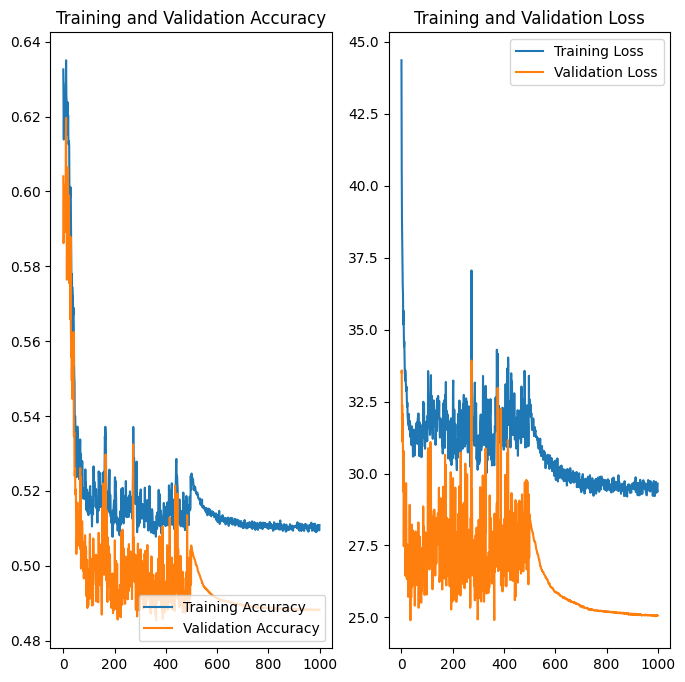

In [32]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

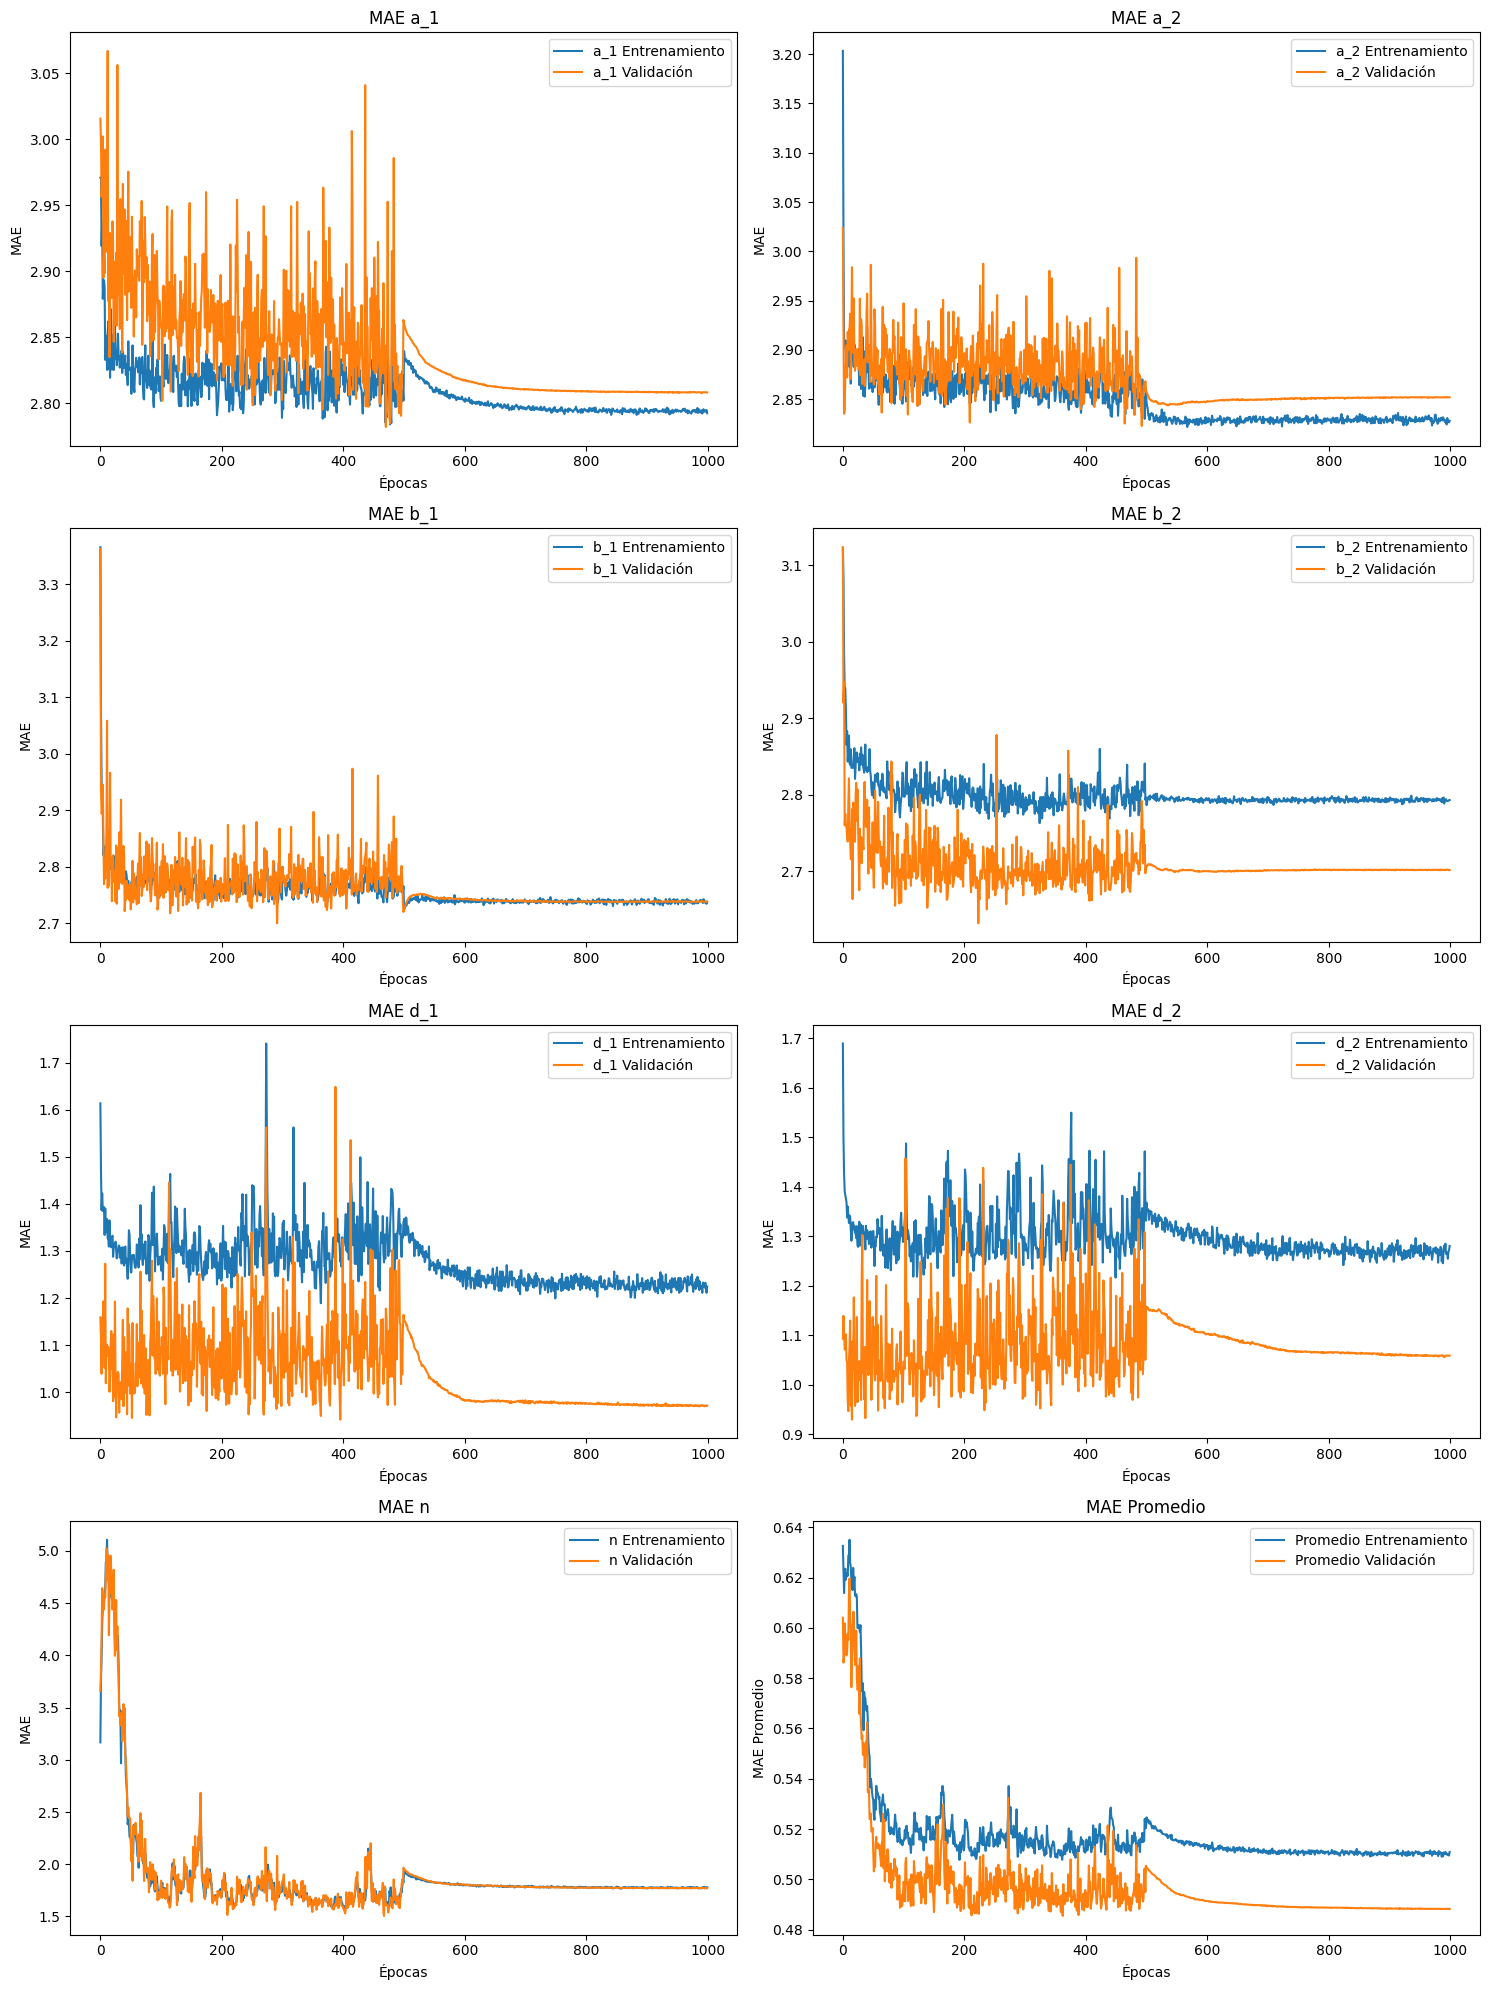

In [33]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [34]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

32/32 [==============================] - 0s 1ms/step - loss: 25.5536 - a_1: 2.7801 - a_2: 2.7614 - b_1: 2.7750 - b_2: 2.7903 - d_1: 0.9997 - d_2: 1.0794 - n: 1.8418 - mean_metric: 0.4930


In [35]:
predictions = model.predict(campvectest)

32/32 [==============================] - 0s 839us/step


In [36]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

[ 7  2 10  1 10  0  1]
[4.0199194 4.4097004 5.430074  5.7251163 8.222709  1.9511049 2.6840563]
[31 32 28 49 25 38 26 42 31 27 24 18 37 33 38 30 24 36 37 38 36 33 20 37
 24 35 39 26 22 26 39 26 38 42 17 23 26 25 36 24 42 34 42 29 38 28 41 30
 34 35 42 16 26 28 40 28 32 40 28 35 28 38 34 32 42 39 38 29 33 38 34 30
 32 39 32 27 31 38 22 36 29 30 35 32 43 32 29 30 41 22 23 47 31 26 34 19
 29 42 30 22 33 38 25 29 36 41 34 40 32 35 40 39 31 38 21 37 43 40 30 41
 31 29 40 31 34 36 54 26 39 29 50 26 47 33 44 11 47 27 33 18 32 43 36 34
 30 34 38 46 24 32 21 48 41 44 42 40 35 29 34 31 33 28 37 30 29 38 35 33
 32 25 38 35 25 27 21 28 38 40 23 38 34 22 42 37 33 20 40 22 35 34 24 33
 37 31 35 31 28 23 36 34 40 25 30 31 34 39 26 26 37 36 45 34 28 30 39 37
 37 35 33 45 31 35 37 31 38 27 35 29 23 51 20 25 31 24 37 43 27 25 27 37
 26 36 36 39 34 23 24 44 31 30 43 41 31 32 40 28 40 32 36 24 47 44 20 28
 29 35 27 30 27 37 53 43 47 46 21 20 20 31 39 28 38 26 36 41 27 30 50 33
 34 37 27 35 23 37 39 32 23 2

2.8710393565041676

In [37]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 2.1470103464807786, Desviación estándar del error: 2.6761318602164557, Error absoluto máximo: 6.250856876373291


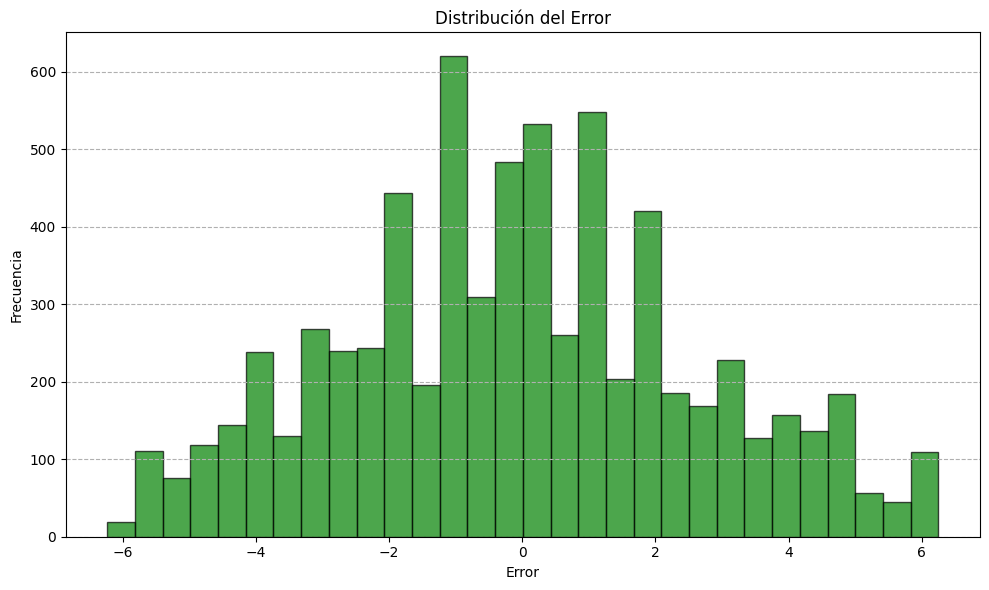

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [39]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.49479696929697775
Desviación estándar del error relativo: 0.2780064730479812
Error absoluto máximo relativo: 2.0083154916763304


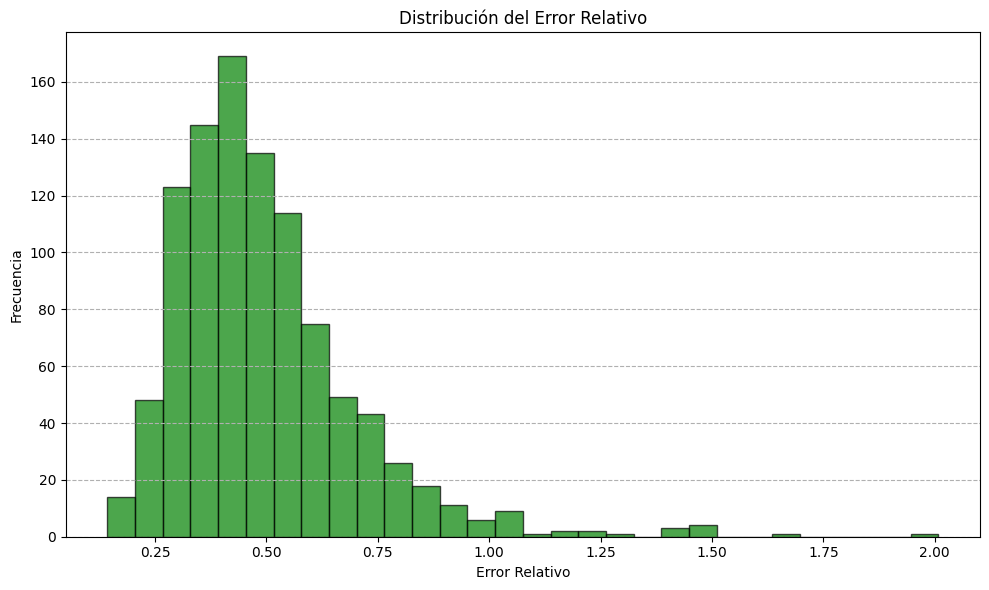

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos Accuracy y Loss

In [41]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historycampvec20funcioncosto.csv', index=False)

# Guardamos el modelo

In [42]:
path_to_save = '../../../Modelos/Modelos 20,50'

In [43]:
model.save(path_to_save + '/campovectorial20funcioncosto.h5')

# Importamos el modelo

In [44]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [45]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [51]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation, 'custom_loss': custom_loss,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)

In [52]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 20,20))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 20,20))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 20)
    y2 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 20,20))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 20,20))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 20)
    y22 = tf.linspace(y_range_neg, y_range_pos, 20)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

In [53]:
new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/campovectorial20funcioncosto.h5', 
                                     custom_objects= custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [55]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)
    contador = contador+1
    print(contador)
    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[3, 5, 2, 0, 2, 4, 4]
1


In [ ]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [ ]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

## Encontramos puntos de equilibrio datos reales

In [ ]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b2
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

## Graficamos con los coeficientes reales

In [ ]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]

y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')
plt.show()

## Encontramos puntos de equilibrio datos predecidos

In [ ]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b2pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

## Graficamos con los coeficientes predecidos

In [ ]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
 
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1 = np.linspace(x_range_neg, x_range_pos, 20)
y2 = np.linspace(y_range_neg, y_range_pos, 20)

Y1, Y2 = np.meshgrid(y1, y2)
    
t1 = 0

u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

u1, v1 = f(t1, [Y1, Y2])
u, v = f(t1, [Y1, Y2])
M = (np.hypot(u, v))
u /= M
v /= M
    
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')